# **Classification Modelling Notebook**

## Objectives

* Fit and evaluate a classification model to predict if a prospect will churn or not.
  
* Train ML Pipeline using hyperparameter optimization with the best features
  
## Inputs

* outputs/datasets/collection/BankCustomerChurn.csv

## Outputs

* Train set (features and target)
  * Test set (features and target)
  
* ML pipeline to predit churn
  
* 
Feature Importance Plot 

## Additional Commen s* 
Deploy Pipeplien. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Bank-Customer-Churn-Prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Bank-Customer-Churn-Prediction'

# Load Data

Section 1 content

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/BankCustomerChurn.csv")
      .drop(labels=['customer_id'], axis=1)
     )
df.head(3)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


---

## ML pipeline for Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineFeatureEngineering():
    pipeline_base = Pipeline([
        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['country', 'gender'])),
       ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary')),

        ("LogTransformer", vt.LogTransformer(variables=['age'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.3, selection_method="variance")),
    ])

    return pipeline_base
PipelineFeatureEngineering()

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary')),
                ('LogTransformer', LogTransformer(variables=['age'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.3))])

In [6]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        # Feature Scaling
        ("scaler", StandardScaler()),
        # Feature Selection
        ("feat_selection", SelectFromModel(model)),
        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

## ML Pipeline for Modelling and Hyperparameter Optimisation
Custom Python Class for hyperparameter optimisation, where we parse the models and hyperparameters for each model Note

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    # We loop the algorithm to do a grid search
    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    # Return summary of the algorithm performance
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['churn'], axis=1),
    df['churn'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 10) (8000,) (2000, 10) (2000,)


## Handle Target Imbalance

In [9]:
pipeline_feat_eng = PipelineFeatureEngineering()
X_train = pipeline_feat_eng.fit_transform(X_train)
X_test = pipeline_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 9) (8000,) (2000, 9) (2000,)


Check Train Set Target distribution

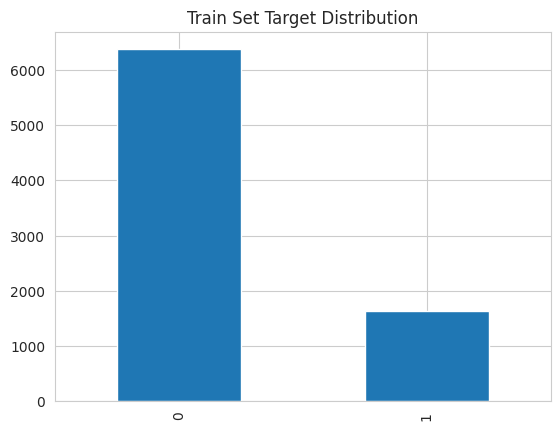

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12736, 9) (12736,) (2000, 9) (2000,)


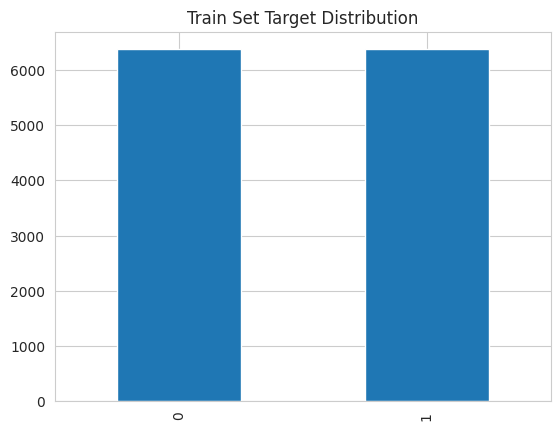

In [12]:
# Check Train Set Target distribution after resampling
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn
We will do an extensive hyperparameter search using the default hyperparameters to find most suitable algorithm. Then we define the hyperparameters for each algorithm using an empty dictionary

In [13]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

In [14]:
# Quick GridSearch CV - Binary Classifier
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
# Check the performance summary
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
4,GradientBoostingClassifier,0.491366,0.809533,0.921507,0.164397
5,ExtraTreesClassifier,0.474097,0.79964,0.911233,0.168417
2,DecisionTreeClassifier,0.167975,0.77296,0.977237,0.308651
0,LogisticRegression,0.55887,0.771525,0.848509,0.109249
1,XGBClassifier,0.356358,0.768551,0.925432,0.213194
3,RandomForestClassifier,0.186028,0.768406,0.957614,0.297614
6,AdaBoostClassifier,0.601256,0.688751,0.763736,0.056599


## Do an extensive search on the algorithms that performed better in a different hyperparameter optimization
We select the 	GradientBoostingClassifier and the ExtraTreesClassifier algorithm for the extensive hyperparameter search with different ranges for the hyperparameter values

In [16]:
models_search = {
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

params_search = {
    "GradientBoostingClassifier":{'model__n_estimators': [100,150],
                                 'model__learning_rate': [0.1, 0.01],
                                 'model__max_depth': [3,4],
                                 # 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
 
                           }, 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html


    "ExtraTreesClassifier":{'model__n_estimators': [50,100],
                         'model__max_depth': [3, 15],
                         'model__min_samples_split': [2, 50],
                         'model__min_samples_leaf': [1,50],
                           }
}

Perforn an extensive search using GridSearch Cross Validation - Binary Classifier

In [17]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [18]:
# Check the performance summary
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__min_samples_leaf,model__n_estimators,model__min_samples_split
4,GradientBoostingClassifier,0.423862,0.827123,0.970958,0.209247,0.1,4,1,100,NaN
1,GradientBoostingClassifier,0.440345,0.822729,0.962294,0.198101,0.1,3,1,150,NaN
5,GradientBoostingClassifier,0.357143,0.818648,0.975667,0.238353,0.1,4,1,150,NaN
3,GradientBoostingClassifier,0.461538,0.817544,0.94187,0.184663,0.1,3,50,150,NaN
6,GradientBoostingClassifier,0.436421,0.815189,0.94584,0.196514,0.1,4,50,100,NaN
7,GradientBoostingClassifier,0.372057,0.811581,0.958399,0.226883,0.1,4,50,150,NaN
0,GradientBoostingClassifier,0.491366,0.809533,0.921507,0.164397,0.1,3,1,100,NaN
2,GradientBoostingClassifier,0.497645,0.799953,0.901021,0.155847,0.1,3,50,100,NaN
25,ExtraTreesClassifier,0.55887,0.791158,0.886881,0.120878,NaN,15,1,100,2
24,ExtraTreesClassifier,0.55887,0.788174,0.880597,0.119388,NaN,15,1,50,2


In [19]:
#Get best model name programmatically
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingClassifier'

In [20]:
#Parameters for best model
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 4,
 'model__min_samples_leaf': 1,
 'model__n_estimators': 100}

We subset the pipelines from the algorithm having the best performance (with best_model), then use .best_estimator_ to retrieve the pipeline that has the algorithm and hyperparameter configuration

In [21]:
#Define the best clf pipeline
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model',
                 GradientBoostingClassifier(max_depth=4, random_state=0))])

## Assess feature importance
We can check the most important features with .feature_importances_ (Note: This has been adapted from the Code Institute learning material Scikit-Learn)

In [22]:
X_train.head(3)

,credit_score,country,gender,age,tenure,balance,credit_card,active_member,estimated_salary
0,667,0,0,3.526361,5,0.00,1,0,163830.64
1,427,1,1,3.737670,1,75681.52,1,1,57098.00
2,535,2,0,3.367296,2,112367.34,1,0,185630.76


* These are the 3 most important features in descending order. The model was trained on them: 
['age', 'active_member', 'gender']


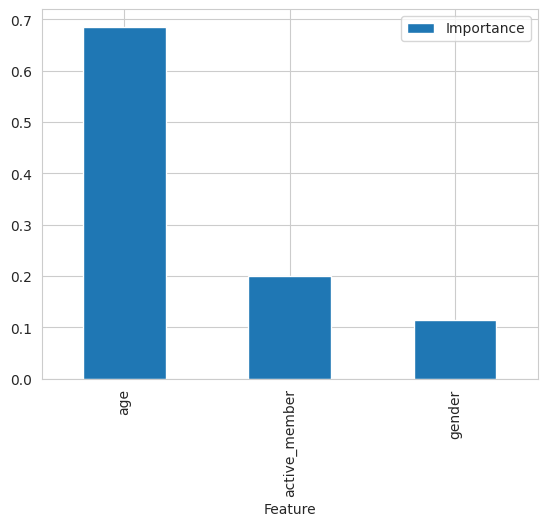

In [23]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluate Performance

In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            5809         1065
Prediction Churn                559         5303


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.85      0.91      0.88      6368
       Churn       0.90      0.83      0.87      6368

    accuracy                           0.87     12736
   macro avg       0.87      0.87      0.87     12736
weighted avg       0.87      0.87      0.87     12736
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            1460          207
Prediction Churn                135          198


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.88      0.92      0.90      1595
       Churn       0.59      0.49      0.54       405

    accuracy                           0.83      

The model shows overfitting between the Test and Train Sets

## Refit pipeline with best features

In [26]:
best_features

['age', 'active_member', 'gender']

In [27]:
#New Pipeline for FeatureEngineering
def PipelineFeatureEngineering():
    pipeline_base = Pipeline([

        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                              variables=['country', 'gender'])),
        ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary')),
        ("LogTransformer", vt.LogTransformer(variables=['age'])),


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base

## Rewrite ML Pipeline for Modelling

In [28]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base

## Split Train Test Set, considering only with best features


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['churn'], axis=1),
    df['churn'],
    test_size=0.2,
    random_state=0,
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 10) (8000,) (2000, 10) (2000,)


In [30]:
#We filter only the most important variables
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(8000, 3) (8000,) (2000, 3) (2000,)


,age,active_member,gender
7389,34,0,Female
9275,42,1,Male
2995,29,0,Female


## Handle Target Imbalance

In [31]:
pipeline_feat_eng = PipelineFeatureEngineering()
X_train = pipeline_feat_eng.fit_transform(X_train)
X_test = pipeline_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 3) (8000,) (2000, 3) (2000,)


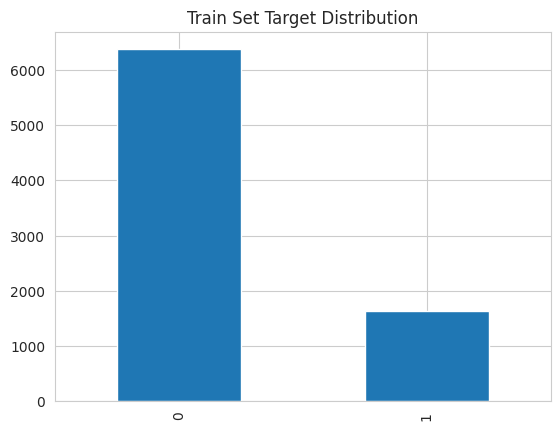

In [32]:
#Check Train Set Target distribution
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [33]:
#Use SMOTE to balance Train Set target
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12736, 3) (12736,) (2000, 3) (2000,)


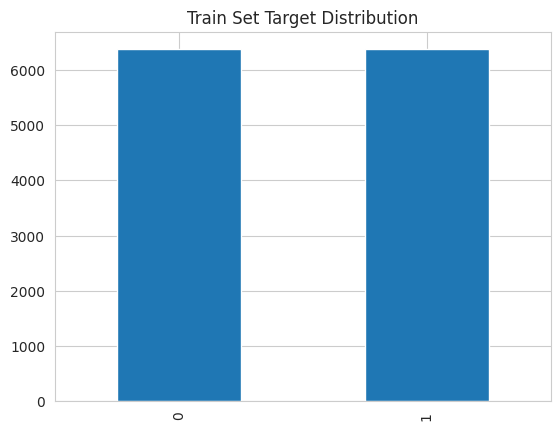

In [34]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn
We list the model that performed best with the best parameters

In [35]:
models_search = {
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
}

params_search = {
    "GradientBoostingClassifier":{'model__n_estimators': [100],
                                 'model__learning_rate':[0.1],
                                 'model__max_depth': [4],
                                 # 'model__min_samples_split': [2],
                                 'model__min_samples_leaf': [1],

                           } 
}

In [36]:
#GridSearch CV
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [37]:
#Check results
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__min_samples_leaf,model__n_estimators
0,GradientBoostingClassifier,0.66248,0.701633,0.742543,0.027033,0.1,4,1,100


In [38]:
#Define the best clf pipeline
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(max_depth=4, random_state=0))])

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['age', 'active_member', 'gender']


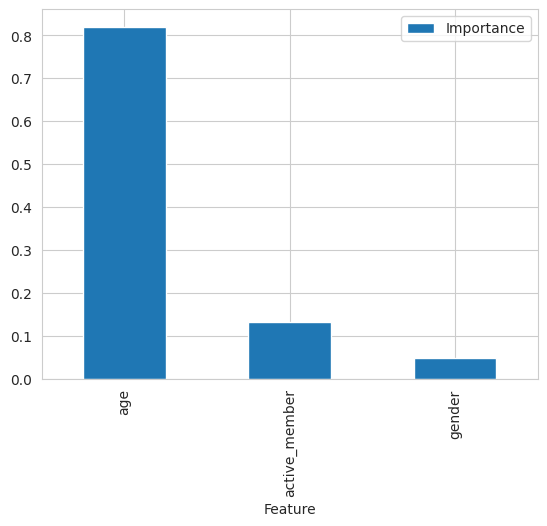

In [39]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [40]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            4860         1880
Prediction Churn               1508         4488


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.72      0.76      0.74      6368
       Churn       0.75      0.70      0.73      6368

    accuracy                           0.73     12736
   macro avg       0.73      0.73      0.73     12736
weighted avg       0.73      0.73      0.73     12736
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            1201          121
Prediction Churn                394          284


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.91      0.75      0.82      1595
       Churn       0.42      0.70      0.52       405

    accuracy                           0.74      

In summary, the model shows a 70% recall on churn and a 72% precision on no-churn on the test set, along with a 70% recall on churn and a 91% precision on no-churn on the train set, are positive indications, but the model's performance should be evaluated in the context of the business goals and operational constraints.

Training Set Accuracy (73%): This indicates that, on the training data, the model correctly classified approximately 73% of all data points. In other words, out of all the instances in the training set, 73% were predicted correctly by the model.

Test Set Accuracy (74%): This represents the model's performance on data it has not seen during training. An accuracy of 74% on the test set means that, on unseen data, the model correctly classified approximately 74% of all instances.

The fact that the test set accuracy is similar to the training set accuracy is generally a positive sign. It suggests that the model is not overfitting the training data, as the performance on unseen data is relatively consistent. 

## Push files to Repo

We will generate the following files
*
Train * * t
Tess* * et
Modeling pel* * ine
features importance plot

In [41]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/bank_churn/{version}'

try:
    os.makedirs(name=file_path) # create a folder to store the files
except Exception as e:
    print(e)

## Train Set: fdeatures and target

In [42]:
print(X_train.shape)
X_train.head()

(12736, 3)


,age,active_member,gender
0,3.526361,0,0
1,3.737670,1,1
2,3.367296,0,0
3,3.688879,0,1
4,4.043051,1,0


In [43]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False) # save train set target

In [44]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
12731    1
12732    1
12733    1
12734    1
12735    1
Name: churn, Length: 12736, dtype: int64

In [45]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [46]:
print(X_test.shape)
X_test.head()

(2000, 3)


,age,active_member,gender
9394,3.555348,1,0
898,3.688879,0,0
2398,3.737670,1,0
5906,3.465736,0,1
2343,3.637586,1,1


In [47]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [48]:
y_test

9394    0
898     1
2398    0
5906    0
2343    0
       ..
1037    0
2899    0
9549    0
2740    0
6690    0
Name: churn, Length: 2000, dtype: int64

In [49]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

---

# Modelling pipeline
We will save 2 pipelines:

Both should be used in conjunction to predict Live Data.
To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.
Pipeline responsible for Data Cleaning and Feature Engineering.

pipeline_feat_eng

In [50]:
joblib.dump(value=pipeline_feat_eng ,
            filename=f"{file_path}/clf_pipeline_feat_eng.pkl")

['outputs/ml_pipeline/bank_churn/v1/clf_pipeline_feat_eng.pkl']

In [51]:
#pipeline responsible for Feature Scaling, and Model
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(max_depth=4, random_state=0))])

In [52]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/bank_churn/v1/clf_pipeline_model.pkl']

## Feature Importance plot

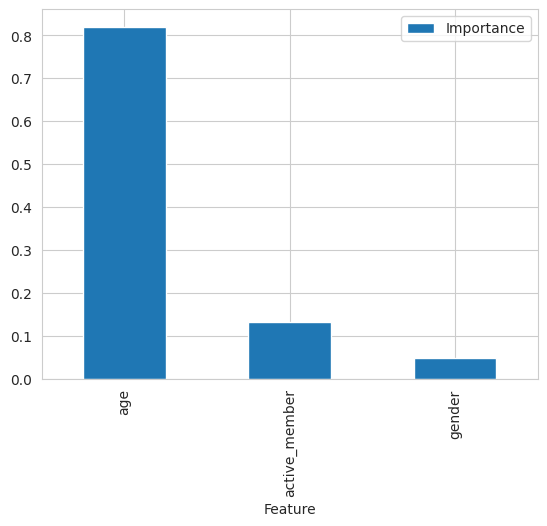

In [53]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

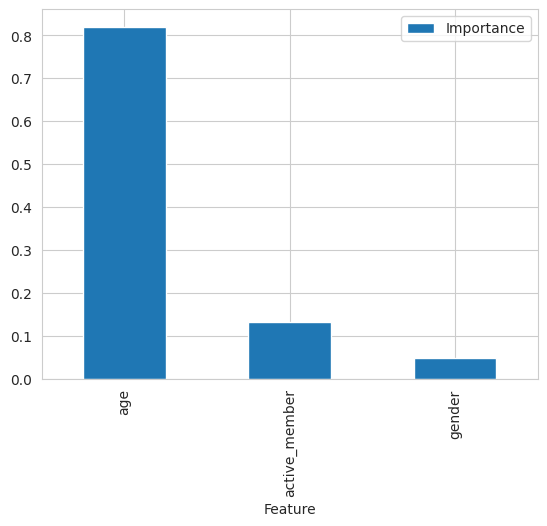

In [54]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')